In [16]:
import warnings
from pathlib import Path

import iris
import iris.cube
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

In [17]:
from aeolus.model import um
from aeolus.synthobs import (
    calc_stellar_flux,
    calc_transmission_spectrum,
    calc_transmission_spectrum_day_night_average,
    read_normalized_stellar_flux,
    read_spectral_bands,
)

In [18]:
warnings.filterwarnings("ignore", module="iris")
plt.rcParams["mathtext.default"] = "regular"

In [19]:
# Note that the file paths should be pathlib.Path-like objects, not just plain strings!
SPECTRUM_DIR = Path.cwd().parent.parent.parent / "data" / "dc605" / "For_WASP-96b_Students" 

DATA_DIR = Path.cwd().parent / "cylc-run" / "u-cp389" / "work" / "1" / "atmos_base_0000"

#/home/um/um/uoesa_data/current/spectral/HD209_CK/
#/data/bm424/cylc-run/u-co736/work/1/atmos_base_0000
#/data/dc605/For_WASP-96b_Students

In [20]:
print(SPECTRUM_DIR)

print(Path.cwd().parent)
print(DATA_DIR)

/data/dc605/For_WASP-96b_Students
/home/bm424
/home/bm424/cylc-run/u-cp389/work/1/atmos_base_0000


In [21]:
spectral_file = SPECTRUM_DIR / "spec_file_wasp96b_mdh1_sw_500"
data_file = DATA_DIR / "atmosa.pd00000000_00"
pd0 = iris.load(data_file)

print(pd0)
spectrum_data = pd0.extract_cube("m01s01i755")


# To keep the units of stellar and planetary parameters, store the parameters as iris cubes
stellar_constant_at_1_au = iris.cube.Cube(
    1275.359867, units="W m-2", long_name="stellar_constant_at_1_au"
)
stellar_radius = iris.cube.Cube(7.31e8, units="m", long_name="stellar_radius")
planet_radius = iris.cube.Cube(83893200, units="m", long_name="planet_radius")
planet_domain_height = iris.cube.Cube(9737675.52477816, units="m", long_name="height_domain")
planet_top_of_atmosphere = planet_radius + planet_domain_height

0: m01s01i755 / (unknown)              (pseudo_level: 500; time: 2; latitude: 90; longitude: 144)
1: toa_incoming_shortwave_flux / (W m-2) (time: 2; latitude: 90; longitude: 144)
2: toa_outgoing_longwave_flux / (W m-2) (time: 2; latitude: 90; longitude: 144)
3: toa_outgoing_shortwave_flux / (W m-2) (time: 2; latitude: 90; longitude: 144)


In [22]:
read_spectral_bands(spectral_file)[0:4]  # print the first four spectral bands


array([(1, 9.9999997e-05, 9.9999998e-03),
       (2, 4.9999999e-05, 9.9999997e-05),
       (3, 3.3333334e-05, 4.9999999e-05),
       (4, 2.4999999e-05, 3.3333334e-05)],
      dtype=[('spectral_band_index', '<u4'), ('lower_wavelength_limit', '<f4'), ('upper_wavelength_limit', '<f4')])

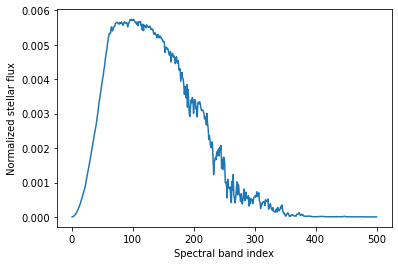

In [23]:
normalized_stellar_flux = read_normalized_stellar_flux(spectral_file)

plt.plot(
    normalized_stellar_flux.coord("spectral_band_index").points,
    normalized_stellar_flux.data,
)
plt.xlabel("Spectral band index")
plt.ylabel("Normalized stellar flux");

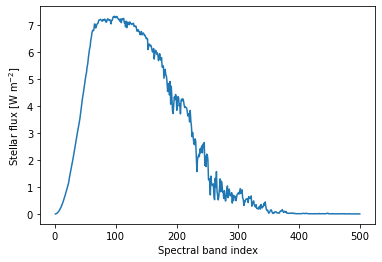

In [24]:
stellar_flux = calc_stellar_flux(spectral_file, stellar_constant_at_1_au)

plt.plot(stellar_flux.coord("spectral_band_index").points, stellar_flux.data)
plt.xlabel("Spectral band index")
plt.ylabel("Stellar flux [W $m^{-2}$]");

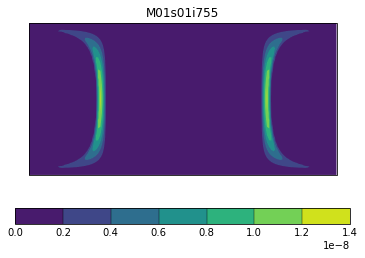

In [25]:

spectrum_data_1time = spectrum_data[:,1,:,:]

#spectrum_data_1time

#print(spectrum_data.shape)

qplt.contourf(spectrum_data_1time[2, ...]);




In [26]:
rp_eff_over_rs = calc_transmission_spectrum(
    spectrum_data_1time,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)

In [27]:
print(stellar_flux.shape)

print(spectrum_data_1time.shape)

(500,)
(500, 90, 144)


In [28]:
rp_eff_over_rs.data

array([0.125938  , 0.12727834, 0.12737329, 0.12723317, 0.12710233,
       0.12718342, 0.12779629, 0.12728486, 0.12633782, 0.12609357,
       0.12632896, 0.12654565, 0.12689409, 0.12708156, 0.12733391,
       0.12709848, 0.12697771, 0.12722183, 0.12712254, 0.12708109,
       0.12725972, 0.12763277, 0.12854889, 0.12789463, 0.12572869,
       0.12533101, 0.12551806, 0.12587794, 0.1262198 , 0.12646628,
       0.12669056, 0.12705127, 0.12735981, 0.12763873, 0.12789033,
       0.12807225, 0.12809025, 0.12791017, 0.12752762, 0.12738822,
       0.12692003, 0.12648767, 0.12614217, 0.12579753, 0.12559117,
       0.12561158, 0.12571891, 0.12612068, 0.12661609, 0.12708674,
       0.12712915, 0.12710508, 0.12701221, 0.12724346, 0.12708218,
       0.1268453 , 0.1264679 , 0.12613183, 0.12560736, 0.12521008,
       0.12536714, 0.12546114, 0.12573505, 0.12608819, 0.12644883,
       0.12680015, 0.12708236, 0.12728609, 0.12740254, 0.12762766,
       0.1276423 , 0.12745319, 0.12750659, 0.1273471 , 0.12705

In [29]:
rp_eff_over_rs

Ratio Of Effective Planetary Radius To Stellar Radius (1),spectral_band_index
Shape,500
Dimension coordinates,
spectral_band_index,x
Auxiliary coordinates,
spectral_band_centres,x
Scalar coordinates,forecast_period 1.008333333360497 hours
forecast_reference_time 2002-05-24 09,"0:00latitude 0.0 degrees, bound=(-89.0, 89.0) degreeslongitude 181.25 degrees, bound=(1.25, 361.25) degrees"
time 2002-05-24 10,0:30
Attributes,source 'Data from Met Office Unified Model'um_version '11.6'


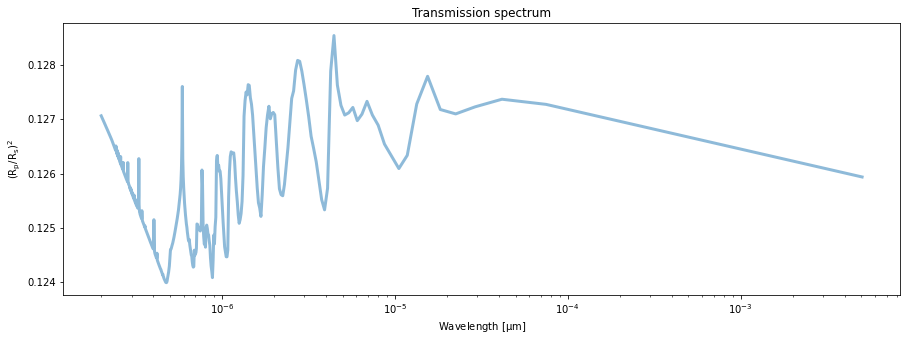

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))


ax.plot(
        rp_eff_over_rs.coord("spectral_band_centres").points, #* 1e6,
        rp_eff_over_rs.data,
        #label="Dayside",
        linewidth=3,
        alpha=0.5,
    )
   
ax.set_title("Transmission spectrum")
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("($R_p/R_s)^2$")
ax.set_xscale("log")
#plt.xlim([0,1])

# xticks = np.concatenate(
#     [
#         np.arange(1, 11, 1),
#         np.arange(15, 35, 5),
#         np.arange(40, 120, 20),
        
       
#     ]
# )
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticks)
# #ax.indicate_inset_zoom(axins, edgecolor="black")
# ax.legend(loc="lower left");
